# The Ultimate Guide to Pricing Options and Implied Volatility With Python

Import modules

In [1]:
# magic function to plot inline
%matplotlib inline
# python standard modules
import time
import datetime as dt 
from math import sqrt, pi
# import numpy, pyplot and scipy
import numpy as np
import pandas as pd
from pandas_datareader.yahoo.options import Options
from pandas_datareader.yahoo.daily import YahooDailyReader 
import matplotlib as mat
mat.style.use("ggplot")
import matplotlib.pyplot as plt
# for plotting the vol surface
from mpl_toolkits.mplot3d import Axes3D 
import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
print(
f"Numpy {np.__version__}\nMatplotlib {mat.__version__}\nScipy {scipy.__version__}\nPandas {pd.__version__}"
)

Numpy 1.23.1
Matplotlib 3.7.2
Scipy 1.11.1
Pandas 1.4.4


## Calculate PnL (profit and loss, payoff, risk profile) chart

In [2]:
# underlying stock price
S = 45.0
# series of underlying stock prices to demonstrate a payoff profile
S_ = np.arange(35.0, 55.0, 0.01) 
# strike price
K = 45.0
# time to expiration (you'll see this as T-t in the equation) (as a part of the year e.g. 6 months as 0.5)
t = 164.0 / 365.0
# risk free rate (there's nuance to this which we'll describe later)
r = 0.02
# volatility (latent variable which is the topic of this talk)
vol = 0.25
# black scholes prices for demonstrating trades
atm_call_premium = 3.20 
atm_put_premium = 2.79
otm_call_premium = 1.39 
otm_put_premium = 0.92

# use a lambda for a payoff functions
# equivelant to:
#
# def call_payoff(S, K):
#     return np.maximum(S - K, 0.0)
call_payoff = lambda S, K: np.maximum(S_ - K, 0.0)
# equivelant to:
#
# def put_payoff(S, K):
# return np.maximum(K - S, 0.0)
put_payoff = lambda S, K: np.maximum(K - S_, 0.0)

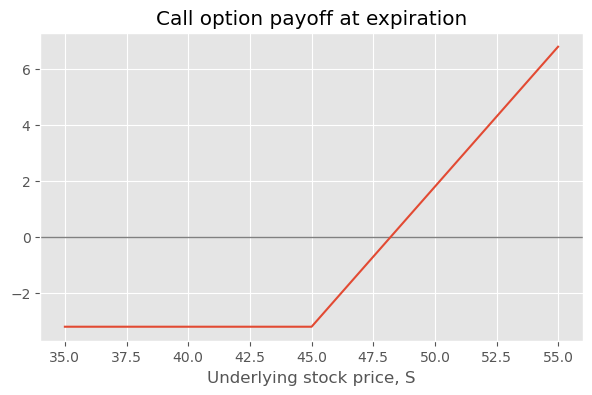

In [3]:
# plot the call payoff
plt.figure(1, figsize=(7, 4))
plt.title("Call option payoff at expiration") 
plt.xlabel("Underlying stock price, S") 
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, -atm_call_premium + call_payoff(S_, K))

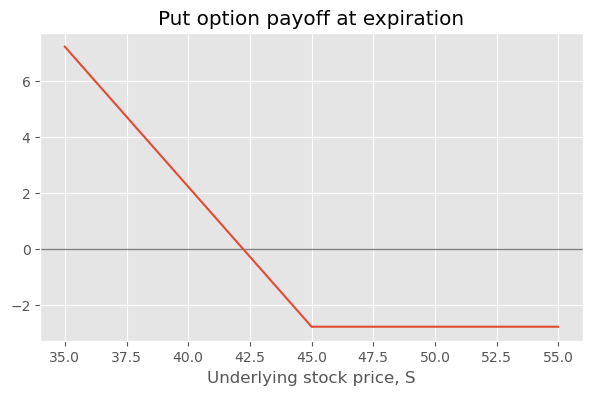

In [4]:
# plot the put payoff
plt.figure(2, figsize=(7, 4))
plt.title("Put option payoff at expiration") 
plt.xlabel("Underlying stock price, S") 
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, -atm_put_premium + put_payoff(S_, K))

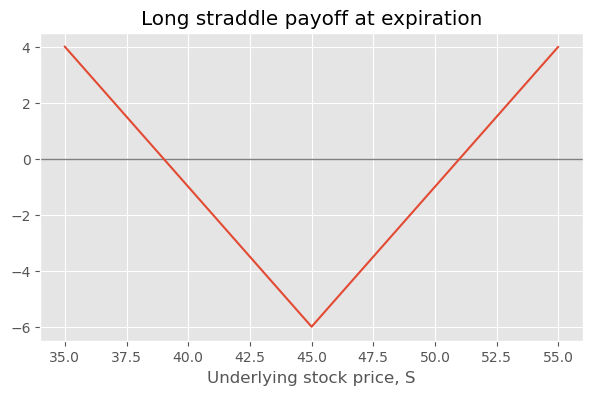

In [5]:
# plot a long straddle payoff
long_straddle = call_payoff(S_, K) + put_payoff(S_, K) 
long_straddle_premium = -atm_call_premium - atm_put_premium 
plt.figure(3, figsize=(7, 4))
plt.title("Long straddle payoff at expiration") 
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, long_straddle_premium + long_straddle)

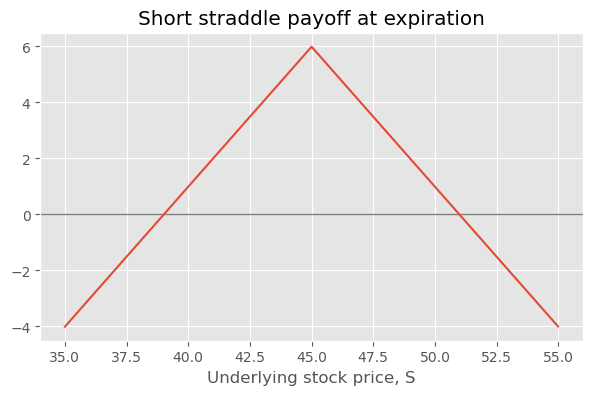

In [6]:
# plot a short straddle payoff
short_straddle = -call_payoff(S_, K) - put_payoff(S_, K) 
short_straddle_premium = atm_call_premium + atm_put_premium 
plt.figure(4, figsize=(7, 4))
plt.title("Short straddle payoff at expiration") 
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, short_straddle_premium - long_straddle)

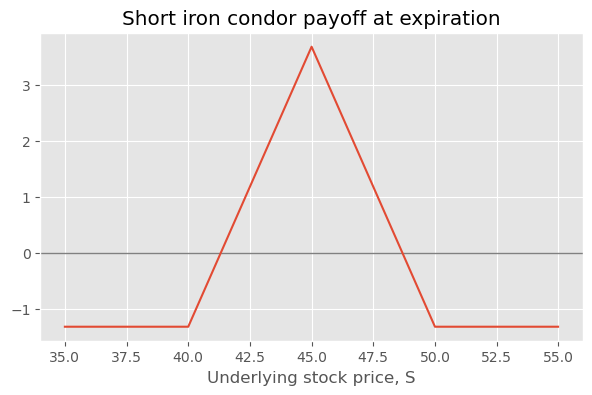

In [7]:
# plot a short iron condor payoff
short_iron_condor = ( call_payoff(S_, K + 5) - call_payoff(S_, K)
- put_payoff(S_, K)
+ put_payoff(S_, K - 5)
)
short_iron_condor_premium = (
-otm_call_premium + atm_call_premium + atm_put_premium - otm_put_premium )
plt.figure(5, figsize=(7, 4))
plt.title("Short iron condor payoff at expiration") 
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, short_iron_condor_premium + short_iron_condor)

## Black-Scholes formula
My attempt at creating from the equations

In [8]:
def N(z):
    """ Normal cumulative density function
    :param z: point at which cumulative density is calculated 
    :return: cumulative density under normal curve
    """
    return norm.cdf(z)

def black_scholes_call_value(S, K, r, t, vol): 
    """ Black-Scholes call option
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS call option value
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    d2 = d1 - (vol * np.sqrt(t))
    return N(d1) * S - N(d2) * K * np.exp(-r * t) 

def black_scholes_put_value(S, K, r, t, vol):
    """ Black-Scholes put option
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS put option value
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    d2 = d1 - (vol * np.sqrt(t))
    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S

In [9]:
call_value = black_scholes_call_value(S, K, r, t, vol) 
put_value = black_scholes_put_value(S, K, r, t, vol)
print(f"Black-Scholes call value {call_value:.2f}")
print(f"Black-Scholes put value {put_value:.2f}")

Black-Scholes call value 3.20
Black-Scholes put value 2.79


As the functions are vectorised, we can plot the black scholes call value along a range of stock prices. Let's try three, six, and one months

In [10]:
# get the value of the option with six months to expiration
black_scholes_call_value_six_months = (
    black_scholes_call_value(S_, K, r, 0.5, vol) - atm_call_premium
)

# get the value of the option with three months to expiration
black_scholes_call_value_three_months = (
    black_scholes_call_value(S_, K, r, 0.25, vol) - atm_call_premium
)

# get the value of the option with nine months to expiration
black_scholes_call_value_one_month = (
    black_scholes_call_value(S_, K, r, 1/12, vol) - atm_call_premium
)

# get payoff value at expiration
call_payoff_at_expiration = call_payoff(S_, K) - atm_call_premium

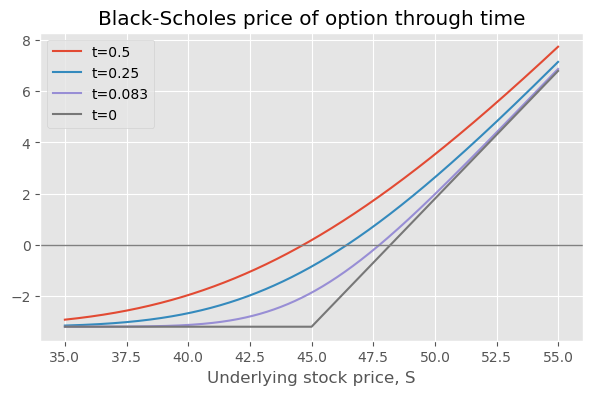

In [11]:
# Plot the stock payoff
plt.figure(3, figsize=(7, 4))
plt.plot(S_, black_scholes_call_value_six_months) 
plt.plot(S_, black_scholes_call_value_three_months) 
plt.plot(S_, black_scholes_call_value_one_month) 
plt.plot(S_, call_payoff_at_expiration) 
plt.axhline(y=0, lw=1, c="grey") 
plt.title("Black-Scholes price of option through time") 
plt.xlabel("Underlying stock price, S") 
plt.legend(["t=0.5", "t=0.25", "t=0.083", "t=0"], loc=2)

### The Greeks
simply partial derivaives of the pricing formula

In [12]:
def call_delta(S, K, r, t, vol):
    """ Black-Scholes call delta
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    return N(d1)

def put_delta(S, K, r, t, vol):
    """ Black-Scholes put delta
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    return N(d1) - 1.0

def phi(x):
    return (np.e**(-(x**2.0)/2.0))/np.sqrt(2.0*np.pi)

def gamma(S, K, r, t, vol):
    """ Black-Scholes gamma
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: gamma
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    return phi(d1)/(S*vol*np.sqrt(t))

def vega(S, K, r, t, vol): 
    """ Black-Scholes vega
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: vega
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    return (S*phi(d1)*np.sqrt(t))/100.0

def call_rho(S, K, r, t, vol):
    """ Black-Scholes call rho
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call rho
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    rho = K*t*(np.e**(-r*t))*N(d2)
    return rho/100.0

def put_rho(S, K, r, t, vol):
    """ Black-Scholes put rho
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put rho
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    rho = -K*t*(np.e**(-r*t))*N(-d2)
    return rho/100.0

def call_theta(S, K, r, t, vol): 
    """ Black-Scholes call theta
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call theta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    d2 = d1 - (vol * np.sqrt(t))
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) - ( 
        r * K * np.exp(-r * t) * N(d2)
    )
    return theta / 365.0

def put_theta(S, K, r, t, vol): 
    """ Black-Scholes put theta
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put theta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t) 
    d2 = d1 - (vol * np.sqrt(t))
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) + ( 
        r * K * np.exp(-r * t) * N(-d2)
    )
    return theta / 365.0

In [13]:
# print each of the results
print("Black-Scholes call delta %0.4f" % call_delta(S, K, r, t, vol)) 
print("Black-Scholes put delta %0.4f" % put_delta(S, K, r, t, vol)) 
print("Black-Scholes gamma %0.4f" % gamma(S, K, r, t, vol)) 
print("Black-Scholes vega %0.4f" % vega(S, K, r, t, vol)) 
print("Black-Scholes call theta %0.4f" % call_theta(S, K, r, t, vol)) 
print("Black-Scholes put theta %0.4f" % put_theta(S, K, r, t, vol)) 
print("Black-Scholes call rho %0.4f" % call_rho(S, K, r, t, vol)) 
print("Black-Scholes put rho %0.4f" % put_rho(S, K, r, t, vol))

Black-Scholes call delta 0.5546
Black-Scholes put delta -0.4454
Black-Scholes gamma 0.0524
Black-Scholes vega 0.1192
Black-Scholes call theta -0.0103
Black-Scholes put theta -0.0078
Black-Scholes call rho 0.0978
Black-Scholes put rho -0.1026


## Realised volatility
often used in models to calibrate for implied volatility

use pandas datareader to compute a 30-day, annualised volatility measure

In [17]:
# fix error: https://stackoverflow.com/questions/74912452/typeerror-string-indices-must-be-integer-pandas-datareader
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# define a stock symbol
underlying_symbol = "IBM"

# define a YahooDailyReader object
# price_obj = YahooDailyReader(underlying_symbol, start="2015-01-01", end="2015-12-31") 
# print(price_obj)

# request historical data
# prices = price_obj.read()
prices = pdr.get_data_yahoo(underlying_symbol, start="2015-01-01", end="2015-12-31")

# yahoo returns prices in ascending order, sort to descending order
prices.sort_index(ascending=False, inplace=True)

# let's pickle the dataframe so we don't have to hit the network every time
prices.to_pickle("underlying_prices.pickle")

[*********************100%%**********************]  1 of 1 completed


In [18]:
 # read the original frame in from cache (pickle)
prices = pd.read_pickle("underlying_prices.pickle")

<Axes: xlabel='Date'>

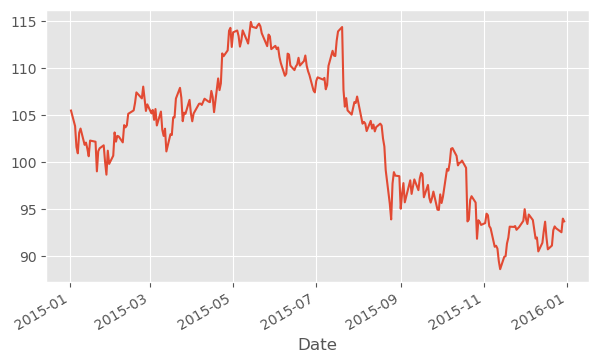

In [24]:
prices["Adj Close"].plot(figsize=(7, 4))

use the last month (approx 22 days) to compute the realized volatility

In [20]:
# compute the log returns from the adjusted closing price
log_return = (prices["Adj Close"] / prices["Adj Close"].shift(-1)).apply(np.log) # take the standard deviation of the last month of data (22 trading days)
sd_of_log_returns = log_return.head(22).std()
# multiply by the square root of the number of trading days in a year (252) to annualize
realized_volatility = sd_of_log_returns * sqrt(252)

In [21]:
print("One month, annualized realized volatility %0.4f" % realized_volatility)

One month, annualized realized volatility 0.1764


In [22]:
# use the pandas DataFrame.rolling method to create a rolling standard deviation of
# log returns, then multiply by square root of 252 to annualize 
rolling_realized_volatility = log_return.rolling(window=22, center=False).std() * sqrt(
252
)

<Axes: title={'center': 'Historic one month, annualized realized volatility'}, xlabel='Date'>

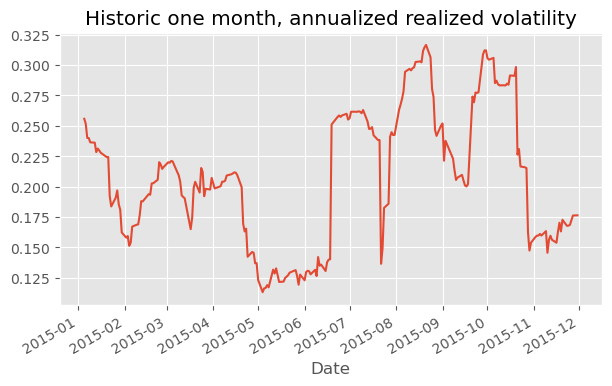

In [23]:
# note that we plot plot directly from a pandas data frame!
rolling_realized_volatility.plot(
title="Historic one month, annualized realized volatility", figsize=(7, 4)
)

# Implied Volatility

the black-scholes pricing formula is often used to solve for implied volatility.

This means setting the formula equal to the observed market price and using a root finding algorithm to get the volatility paameter which sets the difference between model and market price to 0

First, create an objective function which returns the error betwene modle and market price

Second, pass this to the scipy implementation of the Brentq algorithm.

Finally, create an implied volatility function to return the volatility parameter that sets the observed market price to the model price

In [26]:
def call_implied_volatility_objective_function(
        S, K, r, t, vol, call_option_market_price
):
    """ Objective function which sets market and model prices to zero
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """

    return call_option_market_price - black_scholes_call_value(S, K, r, t, vol)

def call_implied_volatility(
        S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6
):
        """ Call implied volatility function
        :param S: underlying
        :param K: strike price
        :param r: rate
        :param t: time to expiration
        :param call_option_market_price: market observed option price
        :param a: lower bound for brentq method
        :param b: upper gound for brentq method
        :param xtol: tolerance which is considered good enough
        :return: volatility to sets the difference between market and model price to zero
        """
        # avoid mirroring outer scope
        _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price

        # define a nested function that takes our target param as the input
        def fcn(vol):
                # returns the difference between market and model price at given volatility
                return call_implied_volatility_objective_function( 
                _S, _K, _r, _t, vol, _call_option_market_price
                )
        
        # first we try to return the results from the brentq algorithm
        try:
               result = brentq(fcn, a=a, b=b, xtol=xtol)

               # if the results are *too* small, sent to np.nan so we can later interpolate
               return np.nan if result <= 1.0e-6 else result 
        
        # if it fails then we return np.nan so we can later interpolate the results
        except ValueError:
               return np.nan
        
def put_implied_volatility_objective_function(
              S, K, r, t, vol, put_option_market_price
              ): 
        """ Objective function which sets market and model prices to zero
        :param S: underlying
        :param K: strike price
        :param r: rate
        :param t: time to expiration
        :param vol: volatility
        :param put_option_market_price: market observed option price
        :return: error between market and model price
        """
        return put_option_market_price - black_scholes_put_value(S, K, r, t, vol)

def put_implied_volatility(
        S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6
):
        """ Puy implied volatility function
        :param S: underlying
        :param K: strike price
        :param r: rate
        :param t: time to expiration
        :param put_option_market_price: market observed option price
        :param a: lower bound for brentq method
        :param b: upper gound for brentq method
        :param xtol: tolerance which is considered good enough
        :return: volatility to sets the difference between market and model price to zero
        """
        # avoid mirroring outer scope
        _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price

        # define a nested function that takes our target param as the input
        def fcn(vol):
                # returns the difference between market and model price at given volatility
                return put_implied_volatility_objective_function( 
                _S, _K, _r, _t, vol, _put_option_market_price
                )
        
        # first we try to return the results from the brentq algorithm
        try:
               result = brentq(fcn, a=a, b=b, xtol=xtol)

               # if the results are *too* small, sent to np.nan so we can later interpolate
               return np.nan if result <= 1.0e-6 else result 
        
        # if it fails then we return np.nan so we can later interpolate the results
        except ValueError:
               return np.nan

In [27]:
# get the call and put values to test the implied volatility output
call_model_price = black_scholes_call_value(S, K, r, t, vol) 
print(
    "Call implied volatility if market and model were equal (should be close to 0.25) %0.6f"
    % call_implied_volatility(S, K, r, t, call_model_price) 
)

put_model_price = black_scholes_put_value(S, K, r, t, vol) 
print(
    "Put implied volatility if market and model were equal (should be close to 0.25) %0.6f"
    % put_implied_volatility(S, K, r, t, put_model_price) 
)

Call implied volatility if market and model were equal (should be close to 0.25) 0.250000
Put implied volatility if market and model were equal (should be close to 0.25) 0.250000


# Getting Real Options Market Data

taken from: https://github.com/pydatasg/PyData-Meetup/tree/master

yahoo no longer supports options data

In [29]:
# define a stock symbol
underlying_symbol = "IBM" # # define a Options object
# options_obj = Options('IBM')
# # request all chains for the underlying symbol
# options_frame_live = options_obj.get_all_data()
# let's pickle the dataframe so we don't have to hit the network every time
# options_frame_live.to_pickle('options_frame.pickle')

In [30]:
# read the original frame in from cache (pickle)
options_frame = pd.read_pickle("options_frame.pickle")

In [31]:
# take a quick look at the DataFrame that returned
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 519 entries, (70.0, Timestamp('2016-07-15 00:00:00'), 'put', 'IBM160715P00070000') to (280.0, Timestamp('2017-01-20 00:00:00'), 'put', 'IBM170120P00280000')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Last              519 non-null    float64       
 1   Bid               519 non-null    float64       
 2   Ask               519 non-null    float64       
 3   Chg               519 non-null    float64       
 4   PctChg            519 non-null    object        
 5   Vol               519 non-null    int64         
 6   Open_Int          519 non-null    int64         
 7   IV                519 non-null    object        
 8   Root              519 non-null    object        
 9   IsNonstandard     519 non-null    bool          
 10  Underlying        519 non-null    object        
 11  Underlying_Price  519 non-null    float64       
 12 

In [32]:
# the first ten records
options_frame.head()

Last    Bid    Ask   Chg  PctChg  \
Strike Expiry     Type Symbol                                                  
70.0   2016-07-15 put  IBM160715P00070000   0.30   0.21   0.35  0.08  36.36%   
       2017-01-20 put  IBM170120P00070000   1.30   0.97   1.40  0.55  73.33%   
       2018-01-19 call IBM180119C00070000  63.00  57.50  62.50  0.00   0.00%   
                  put  IBM180119P00070000   2.30   0.96   2.50  0.32  16.16%   
75.0   2016-07-15 put  IBM160715P00075000   0.41   0.30   0.45  0.01   2.50%   

                                           Vol  Open_Int      IV Root  \
Strike Expiry     Type Symbol                                           
70.0   2016-07-15 put  IBM160715P00070000   15        10  46.63%  IBM   
       2017-01-20 put  IBM170120P00070000   48       118  43.12%  IBM   
       2018-01-19 call IBM180119C00070000   15         4  35.44%  IBM   
                  put  IBM180119P00070000    2        97  35.62%  IBM   
75.0   2016-07-15 put  IBM160715P00075000  166         3  43.95%  IBM   

                                           IsNonstandard Underlying  \
Strike Expiry     Type Symbol                                         
70.0   2016-07-15 put  IBM160715P00070000          False        IBM   
       2017-01-20 put  IBM170120P00070000          False        IBM   
       2018-01-19 call IBM180119C00070000          False        IBM   
                  put  IBM180119P00070000          False        IBM   
75.0   2016-07-15 put  IBM160715P00075000          False        IBM   

                                           Underlying_Price  \
Strike Expiry     Type Symbol                                 
70.0   2016-07-15 put  IBM160715P00070000            130.03   
       2017-01-20 put  IBM170120P00070000            130.03   
       2018-01-19 call IBM180119C00070000            130.03   
                  put  IBM180119P00070000            130.03   
75.0   2016-07-15 put  IBM160715P00075000            130.03   

                                                   Quote_Time  
Strike Expiry     Type Symbol                                  
70.0   2016-07-15 put  IBM160715P00070000 2016-01-18 16:03:00  
       2017-01-20 put  IBM170120P00070000 2016-01-18 16:03:00  
       2018-01-19 call IBM180119C00070000 2016-01-18 16:03:00  
                  put  IBM180119P00070000 2016-01-18 16:03:00  
75.0   2016-07-15 put  IBM160715P00075000 2016-01-18 16:03:00

In [33]:
# reset the index so the strike and expiration become columns
options_frame.reset_index(inplace=True)
# rename the columns for consistency
columns = {
    "Expiry": "Expiration",
    "Type": "OptionType",
    "Symbol": "OptionSymbol",
    "Vol": "Volume",
    "Open_Int": "OpenInterest", 
    "Underlying_Price": "UnderlyingPrice", 
    "Quote_Time": "QuoteDatetime", 
    "Underlying": "UnderlyingSymbol", 
    "Chg": "OptionChange",
}
options_frame.rename(columns=columns, inplace=True)

In [34]:
# make some helper functions to apply to the dataframe
def _get_days_until_expiration(series):
    """ Return the number of days until expiration
        :param series: row of the dataframe, accessible by label
        :return: days until expiration
    """
    expiration = series["Expiration"]
        # add the hours to the expiration date so we get the math correct
    date_str = expiration.strftime("%Y-%m-%d") + " 23:59:59" # convert date string into datetime object
    expiry = dt.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    # get today
    # since we need to use a cached data source, revert to that date
    # today = dt.datetime.today() 
    today = dt.datetime(2016, 1, 18)
        # return the difference and add one to count for today
    return (expiry - today).days + 1

def _get_time_fraction_until_expiration(series):
    """ Return the fraction of a year until expiration
        You don't always have to be this precise. The difference in price
        based on a few hours for long dated options or far OTM options
        will not be affected. However for liquid, ATM options with short
        expiration windows, every second counts!
        :param series: row of the dataframe, accessible by label
        :return: fraction of a year until expiration
    """
    expiration = series["Expiration"]
        # add the hours to the expiration date so we get the math correct
    date_str = expiration.strftime("%Y-%m-%d") + " 23:59:59" # convert date string into datetime object
    time_tuple = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    # get the number of seconds from the epoch until expiration
    expiry_in_seconds_from_epoch = time.mktime(time_tuple)
        # get the number of seconds from the epoch to right now
        #   since we need to use a cached data source, revert to that date
        #   today = dt.datetime.today()
        #   right_now_in_seconds_from_epoch = time.time()
    right_now_in_seconds_from_epoch = dt.datetime(2016, 1, 18).timestamp()
        # get the total number of seconds to expiration
    seconds_until_expiration = (
    expiry_in_seconds_from_epoch - right_now_in_seconds_from_epoch
    )
        # seconds in year
    seconds_in_year = 31536000.0
        # fraction of seconds to expiration to total in year, rounded
    return max(seconds_until_expiration / seconds_in_year, 1e-10)

In [35]:
# define terms and associated rates, these should coincide with our options # these rates are taken from the yield curve
terms = [30, 3 * 30, 6 * 30, 12 * 30, 24 * 30, 36 * 30, 60 * 30]
rates = [0.0001, 0.0009, 0.0032, 0.0067, 0.0097, 0.0144, 0.0184]

def _get_rate(series):
    """ Interpolate rates out to 30 years
            Note computing rates like this is not strictly theoretically
            correct but works for illustrative purposes
        :param series: row of the dataframe, accessable by label
        :return interpolated interest rate based on term structure
    """
    days = series["DaysUntilExpiration"]
        # generate terms for every thirty days up until our longest expiration
    new_terms = [i for i in range(30, (60 * 30) + 1)] 
    # create linear interpolation model
    f = interp1d(terms, rates, kind="linear")
    # interpolate the values based on the new terms we created above
    ff = f(new_terms)
    # return the interpolated rate given the days to expiration
    return round(ff[max(days, 30) - 30], 8)

def _get_mid(series):
    """ Get the mid price between bid and ask
    :param series: row of the dataframe, accessable by label
    :return mid price
    """
    bid = series["Bid"] 
    ask = series["Ask"] 
    last = series["Last"]
        # if the bid or ask doesn't exist, return 0.0
    if np.isnan(ask) or np.isnan(bid): 
        return 0.0
        # if the bid or ask are 0.0, return the last traded price
    elif ask == 0.0 or bid == 0.0: 
        return last
    else:
        return (ask + bid) / 2.0

use axis=1 to apply the functions to each row

In [36]:
# use the apply method to pass each row as a series to the various methods, returns a series in this case
options_frame["DaysUntilExpiration"] = options_frame.apply( 
    _get_days_until_expiration, axis=1
)
options_frame["TimeUntilExpiration"] = options_frame.apply(
    _get_time_fraction_until_expiration, axis=1 
)
options_frame["InterestRate"] = options_frame.apply(
    _get_rate, axis=1
) 
options_frame["Mid"] = options_frame.apply(
    _get_mid, axis=1
)

In [37]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Strike               519 non-null    float64       
 1   Expiration           519 non-null    datetime64[ns]
 2   OptionType           519 non-null    object        
 3   OptionSymbol         519 non-null    object        
 4   Last                 519 non-null    float64       
 5   Bid                  519 non-null    float64       
 6   Ask                  519 non-null    float64       
 7   OptionChange         519 non-null    float64       
 8   PctChg               519 non-null    object        
 9   Volume               519 non-null    int64         
 10  OpenInterest         519 non-null    int64         
 11  IV                   519 non-null    object        
 12  Root                 519 non-null    object        
 13  IsNonstandard        519 non-null  

## Applying implied volatility

In [43]:
def _get_implied_vol_mid(series):
    """
    :return implied volatility of a series (from middle of bid ask spread)
    """
    option_type = series["OptionType"] 
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    mid = series["Mid"]
        # build method name
    meth_name = "{0}_implied_volatility".format(option_type)
        # call from globals()
    return float(globals().get(meth_name)(S, K, r, t, mid))

In [44]:
# apply the function to the dataframe rowwise
options_frame["ImpliedVolatilityMid"] = options_frame.apply( 
    _get_implied_vol_mid, axis=1
)

In [45]:
# again, let's take a look
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Strike                519 non-null    float64       
 1   Expiration            519 non-null    datetime64[ns]
 2   OptionType            519 non-null    object        
 3   OptionSymbol          519 non-null    object        
 4   Last                  519 non-null    float64       
 5   Bid                   519 non-null    float64       
 6   Ask                   519 non-null    float64       
 7   OptionChange          519 non-null    float64       
 8   PctChg                519 non-null    object        
 9   Volume                519 non-null    int64         
 10  OpenInterest          519 non-null    int64         
 11  IV                    519 non-null    object        
 12  Root                  519 non-null    object        
 13  IsNonstandard       

In [46]:
options_frame.head()

,Strike,Expiration,OptionType,OptionSymbol,Last,Bid,Ask,OptionChange,PctChg,Volume,...,Root,IsNonstandard,UnderlyingSymbol,UnderlyingPrice,QuoteDatetime,DaysUntilExpiration,TimeUntilExpiration,InterestRate,Mid,ImpliedVolatilityMid
0,70.0,2016-07-15,put,IBM160715P00070000,0.30,0.21,0.35,0.08,36.36%,15,...,IBM,False,IBM,130.03,2016-01-18 16:03:00,180,0.493151,0.003200,0.280,0.450436
1,70.0,2017-01-20,put,IBM170120P00070000,1.30,0.97,1.40,0.55,73.33%,48,...,IBM,False,IBM,130.03,2016-01-18 16:03:00,369,1.010959,0.006775,1.185,0.418423
2,70.0,2018-01-19,call,IBM180119C00070000,63.00,57.50,62.50,0.00,0.00%,15,...,IBM,False,IBM,130.03,2016-01-18 16:03:00,733,2.008219,0.009870,60.000,NaN
3,70.0,2018-01-19,put,IBM180119P00070000,2.30,0.96,2.50,0.32,16.16%,2,...,IBM,False,IBM,130.03,2016-01-18 16:03:00,733,2.008219,0.009870,1.730,0.330995
4,75.0,2016-07-15,put,IBM160715P00075000,0.41,0.30,0.45,0.01,2.50%,166,...,IBM,False,IBM,130.03,2016-01-18 16:03:00,180,0.493151,0.003200,0.375,0.426392


## Interpolating bad and missing IV values

In the call_implied_volatility and put_implied_volatility functions we test for the Brentq solver blowing up. The solver will blow up if the option's mid price leads to a negative implied volatility. This happens with deep in or out of the money options where market makers keep the bid-ask spread wide.

In [47]:
# Let's find the options where the implied volatility is np.nan
bad_iv = options_frame[np.isnan(options_frame["ImpliedVolatilityMid"])]

In [48]:
# map the count function to each strike where there is a nan implied volatility
bad_iv.groupby(["Strike"]).count()["Expiration"]

Strike
70.0     1
75.0     1
80.0     3
85.0     2
90.0     2
100.0    2
105.0    1
Name: Expiration, dtype: int64

Now to interpolate the missing implied volatility values.

In [49]:
def _interp_implied_volatility(options_frame):
    """ Interpolate missing (np.nan) values of implied volatility
    We first need to split the chains into expiration and type because we cannot interpolate across the entire chain, rather within these two groups
        :param options_frame: DataFrame containing options data
        :return original DataFrame with ImpliedVolatilityMid column containing interpolated values
    """
    # create a MultiIndex with Expiration, OptionType, the Strike as index, then sort
    frame = options_frame.set_index(['Expiration', "OptionType", "Strike"]).sort_index()
    # pivot the frame with ImpliedVolatilityMid as the values within the table
    # this has Strikes along the rows and Expirations along the columns
    # the level=1 unstack pivots on Expiration and level=0 unstack pivots on OptionType
    unstacked = frame['ImpliedVolatilityMid'].unstack(level=1).unstack(level=0)

    # this line does three things:
    #    first interpolates across each Expiration date down the strikes for np.nan values
    #    second forward fills values which keeps the last interpolated value as the value to fill
    #    third back fills values which keeps the first interpolated value as the value to fill 
    unstacked_interp = unstacked.interpolate().ffill().bfill()


    # restack into shape of original DataFrame
    unstacked_interp_indexed = ( 
        unstacked_interp.stack(level=0).stack(level=0).reset_index()
    )


    # replace old column with the new column with interpolated and filled values
    frame["ImpliedVolatilityMid"] = unstacked_interp_indexed.set_index( 
        ["Expiration", "OptionType", "Strike"]
    )

    # give our index back
    frame.reset_index(inplace=True)

    # return
    return frame

In [50]:
# get the completed frame
options_frame = _interp_implied_volatility(options_frame)

In [51]:
# check to see if there are any np.nans
bad_iv_post = options_frame[np.isnan(options_frame["ImpliedVolatilityMid"])]

In [52]:
bad_iv_post.groupby(["Strike"]).count()["Expiration"]

Series([], Name: Expiration, dtype: int64)

## Applying black-scholes and the greeks

In [57]:
def _get_option_value(series):
    """ Return the option value given the OptionType
        :param series: row of the dataframe, accessible by label
        :return: Black-Scholes option value
    """
    option_type = series["OptionType"] 
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    vol = series["ImpliedVolatilityMid"]
    meth_name = "black_scholes_{0}_value".format(option_type) 
    return float(globals().get(meth_name)(S, K, r, t, vol))


def _get_delta(series):
    """ Return the option delta given the OptionType
        :param series: row of the dataframe, accessible by label
        :return: option delta
    """
    option_type = series["OptionType"] 
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    vol = series["ImpliedVolatilityMid"]
    meth_name = "{0}_delta".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_gamma(series):
    """ Return the option gamma
        :param series: row of the dataframe, accessible by label
        :return: option gamma
    """
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    vol = series["ImpliedVolatilityMid"]
    return float(gamma(S, K, r, t, vol))

def _get_vega(series):
    """ Return the option vega
        :param series: row of the dataframe, accessible by label
        :return: option vega
    """
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    vol = series["ImpliedVolatilityMid"]
    return float(vega(S, K, r, t, vol)) 

def _get_theta(series):
    """ Return the option theta given the OptionType
    :param series: row of the dataframe, accessible by label
    :return: option theta
    """
    option_type = series["OptionType"] 
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    vol = series["ImpliedVolatilityMid"]
    meth_name = "{0}_theta".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))
def _get_rho(series):
    """ Return the option rho given the OptionType
        :param series: row of the dataframe, accessible by label
        :return: option rho
    """
    option_type = series["OptionType"] 
    S = series["UnderlyingPrice"]
    K = series["Strike"]
    r = series["InterestRate"]
    t = series["TimeUntilExpiration"] 
    vol = series["ImpliedVolatilityMid"]
    meth_name = "{0}_rho".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

In [58]:
def _get_model_error(series):
    """ Return the error between mid price and model price
        :param series: row of the dataframe, accessible by label
        :return: error between mid price and model price
    """
    option_mid = series["Mid"]
    return option_mid - _get_option_value(series)
# use the apply method to pass each row as a series to the various methods, returns a series in this case
options_frame["TheoreticalValue"] = options_frame.apply(_get_option_value, axis=1) 
options_frame["Delta"] = options_frame.apply(_get_delta, axis=1) 
options_frame["Gamma"] = options_frame.apply(_get_gamma, axis=1) 
options_frame["Vega"] = options_frame.apply(_get_vega, axis=1) 
options_frame["Theta"] = options_frame.apply(_get_theta, axis=1) 
options_frame["Rho"] = options_frame.apply(_get_rho, axis=1) 
options_frame["ModelError"] = options_frame.apply(_get_model_error, axis=1)

In [59]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Expiration            519 non-null    datetime64[ns]
 1   OptionType            519 non-null    object        
 2   Strike                519 non-null    float64       
 3   OptionSymbol          519 non-null    object        
 4   Last                  519 non-null    float64       
 5   Bid                   519 non-null    float64       
 6   Ask                   519 non-null    float64       
 7   OptionChange          519 non-null    float64       
 8   PctChg                519 non-null    object        
 9   Volume                519 non-null    int64         
 10  OpenInterest          519 non-null    int64         
 11  IV                    519 non-null    object        
 12  Root                  519 non-null    object        
 13  IsNonstandard       

In [60]:
options_frame.head()

,Expiration,OptionType,Strike,OptionSymbol,Last,Bid,Ask,OptionChange,PctChg,Volume,...,InterestRate,Mid,ImpliedVolatilityMid,TheoreticalValue,Delta,Gamma,Vega,Theta,Rho,ModelError
0,2016-01-22,call,124.0,IBM160122C00124000,7.03,6.9,7.95,0.00,0.00%,5,...,0.0001,7.425,0.614568,7.425000,0.756824,0.033476,0.047650,-0.292868,0.012464,-6.513059e-09
1,2016-01-22,call,125.0,IBM160122C00125000,9.50,6.5,7.20,0.00,0.00%,5,...,0.0001,6.850,0.641744,6.849999,0.713221,0.034864,0.051821,-0.332583,0.011766,1.079141e-06
2,2016-01-22,call,126.0,IBM160122C00126000,6.05,5.8,6.30,0.25,4.31%,15,...,0.0001,6.050,0.617530,6.050000,0.681449,0.037979,0.054321,-0.335470,0.011309,-1.437312e-07
3,2016-01-22,call,127.0,IBM160122C00127000,5.40,5.2,5.65,0.00,0.00%,4,...,0.0001,5.425,0.619250,5.425000,0.641165,0.039653,0.056873,-0.352205,0.010677,-3.183839e-09
4,2016-01-22,call,129.0,IBM160122C00129000,4.19,4.0,4.40,-1.71,-28.98%,35,...,0.0001,4.200,0.605660,4.200000,0.558691,0.042812,0.060056,-0.363756,0.009376,-5.723567e-09


## Analysing the model error



<Axes: >

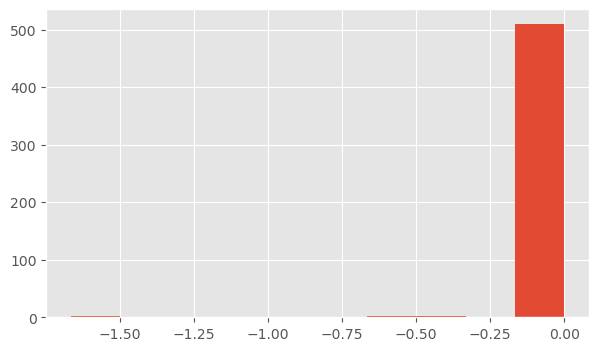

In [62]:
# plot the model error
options_frame["ModelError"].hist(figsize=(7, 4))

What is the explanation?

Based on some of my comments above, our hypothesis should be that deep in or out of the money options largely have wide bid-ask spreads leading to mis-pricing of the options. Let's plot strike v. model error.

<Axes: xlabel='Strike'>

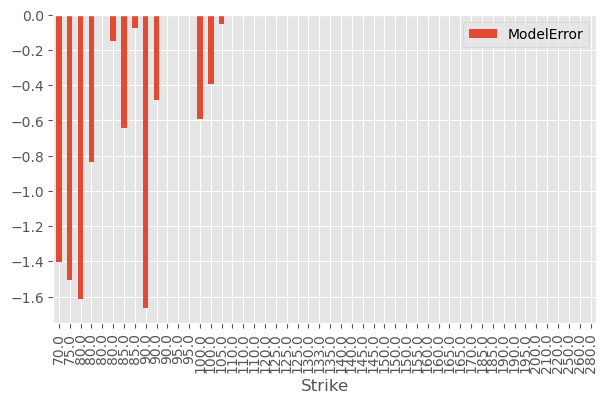

In [64]:
# grab the index of the 50 largest abs(errors)
sorted_errors_idx = ( 
    options_frame["ModelError"].map(abs).sort_values(ascending=False).head(50)
)
# get the rest of the details from the frame
errors_50_largest_by_strike = options_frame.iloc[sorted_errors_idx.index]
# plot model error against strike
errors_50_largest_by_strike[["Strike", "ModelError"]].sort_values(by="Strike").plot( 
    kind="bar", x="Strike", figsize=(7, 4)
)

plot bid ask spread against against model error

<Axes: xlabel='BidAskSpread'>

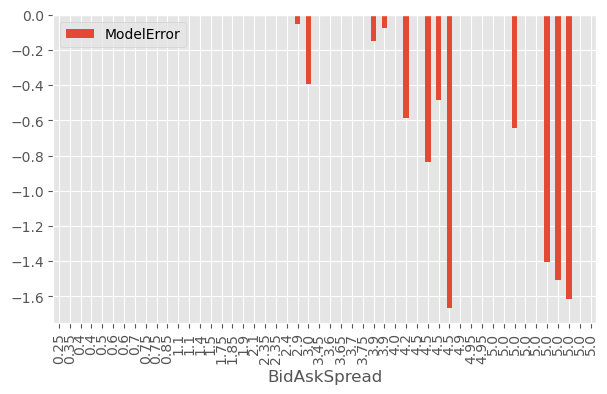

In [65]:
# add a new column
options_frame["BidAskSpread"] = (options_frame["Ask"] - options_frame["Bid"]).round(4) # plot model error by bid-ask spread
errors_50_largest_by_spread = options_frame.iloc[sorted_errors_idx.index]
# plot model error against strike, many expirations included
errors_50_largest_by_spread[["BidAskSpread", "ModelError"]].sort_values( by="BidAskSpread"
).plot(kind="bar", x="BidAskSpread", figsize=(7, 4))

let's take a look at the relationship between model error and bid-ask spread

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='BidAskSpread', ylabel='ModelError'>

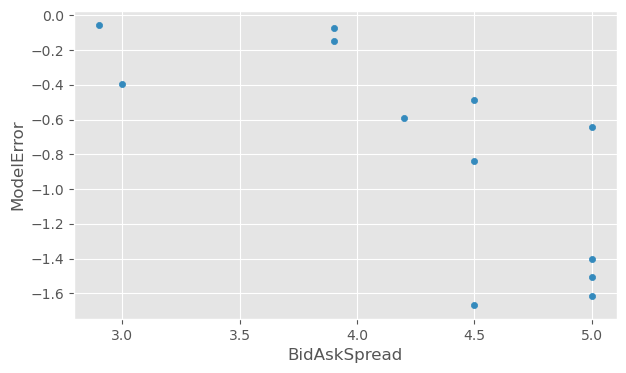

In [66]:
# plot a scatter plot of all errors > 1.0e-4
options_frame[abs(options_frame["ModelError"]) >= 1.0e-4].plot( kind="scatter", x="BidAskSpread", y="ModelError", figsize=(7, 4)
)

## Analysing implied volatility

<Axes: title={'center': 'Implied volatility skew'}, xlabel='Strike'>

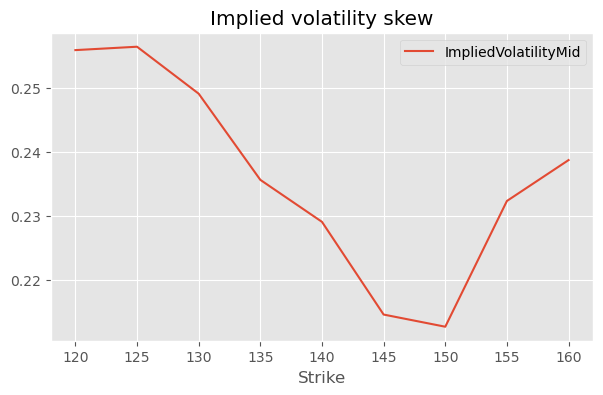

In [67]:
#  select an expiration to plot
iv = options_frame[options_frame["Expiration"] == "2016-03-18"] # get the call options
iv_call = iv[iv["OptionType"] == "call"]
# set the strike as the index so pandas plots nicely
iv_call[["Strike", "ImpliedVolatilityMid"]].set_index("Strike").plot( title="Implied volatility skew", figsize=(7, 4)
)

multi-expiration skew chart

<Axes: xlabel='Strike'>

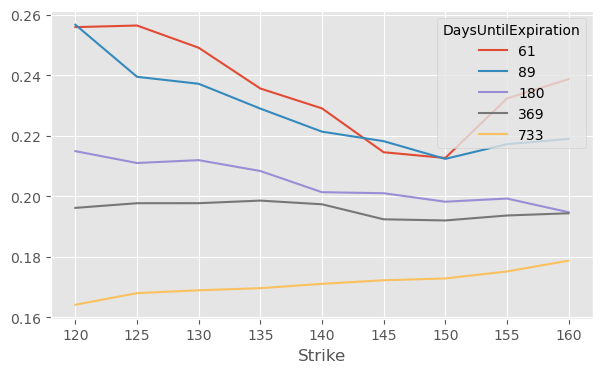

In [69]:
# get the monthly expirations
expirations = options_frame["Expiration"].unique()[-5:]
# get all the rows where expiration is in our list of expirations
iv_multi = options_frame[options_frame["Expiration"].isin(expirations)] # get the call options
iv_multi_call = iv_multi[iv_multi["OptionType"] == "call"]
# pivot the data frame to put expiration dates as columns
iv_pivoted = (
iv_multi_call[["DaysUntilExpiration", "Strike", "ImpliedVolatilityMid"]].pivot(index="Strike", columns="DaysUntilExpiration", values="ImpliedVolatilityMid") .dropna()
)
# plot
iv_pivoted.plot(figsize=(7, 4))

take a look at term structure for volatility

<Axes: xlabel='Expiration'>

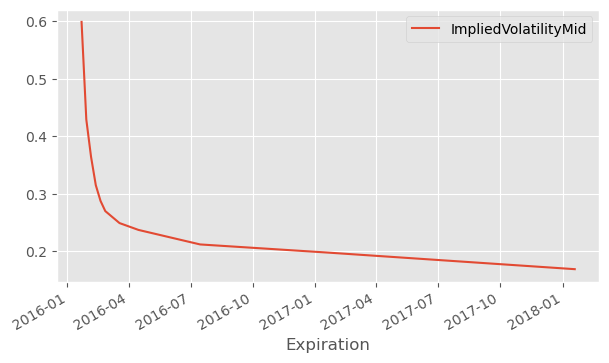

In [70]:
# select a strike to plot
iv = options_frame[options_frame["Strike"] == 130.0] # get the call options
iv_call = iv[iv["OptionType"] == "call"]
# set the strike as the index so pandas plots nicely
iv_call[["Expiration", "ImpliedVolatilityMid"]].set_index("Expiration").plot( figsize=(7, 4)
)

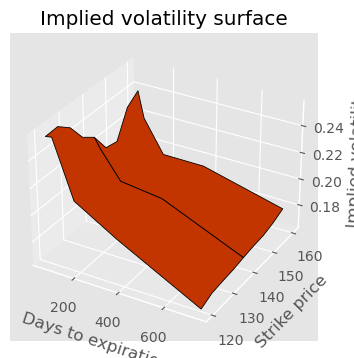

In [72]:
# pivot the dataframe
iv_pivoted_surface = iv_multi_call[['DaysUntilExpiration', 'Strike', 'ImpliedVolatilityMid']].pivot(index='Strike', columns='DaysUntilExpiration', values='ImpliedVolatilityMid').dropna()
# create the figure object
fig = plt.figure(figsize=(7, 4))
# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')
# get the 1d values from the pivoted dataframe
x, y, z = iv_pivoted_surface.columns.values, iv_pivoted_surface.index.values, iv_pivoted_surface.values # return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)
# set labels
ax.set_xlabel('Days to expiration') 
ax.set_ylabel('Strike price') 
ax.set_zlabel('Implied volatility') 
ax.set_title('Implied volatility surface')
# plot
ax.plot_surface(X, Y, z, rstride=4, cstride=4, color='orangered', edgecolors='k', lw=0.6)